In [18]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# VEST AL 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Alabama Secretary of State Elections Division (https://www.sos.alabama.gov/alabama-votes/voter/election-data). 

#### Processing
Absentee and provisional ballots were reported countywide in all counties. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.


### Shapefiles

#### Sources
Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

### Processing
Precinct boundaries were adjusted as appropriate to align with county maps, municipal boundaries, or commission districts. Precinct boundaries throughout the state were further reviewed with the voter registration file in effect for the November 2020 general election. Voting districts in nearly all counties were edited accordingly to align with reporting units in the 2020 election results. In many counties the resulting boundaries bear little resemblance to the 2020 Census VTDs. As these boundary revisions were so extensive only splits and merges are specified below by precinct.

Many precincts have outdated names in the Census VTDs. The Census VTDs also have at least some precinct names in wrong locations for the following counties: Clarke, Clay, Cleburne, Conecuh, Dallas, Escambia, Geneva, Greene, Jefferson, Lauderdale, Limestone, Marion, Marshall, Monroe, Perry, Randolph, Russell, Tallapoosa, Walker, Washington, Wilcox. Moreover, many precinct numbers and consequently the VTD GeoIDs are also incorrect throughout much of the state in the Census shapefiles. All precinct names and numbers have been edited to match the 2020 voter file.

The following splits and merges were made to align voting district boundaries with reporting units in the 2020 election results.

- Barbour: Split Eufaula between Bevill/CC/Fellowship/McCoo/Sanford/WB
- Calhoun: Add precinct splits to Beats 1, 4, 5, 9, 12, 13, 15, 19, 22
- Cherokee: Split Friendship/Mt Calvary, McCord's/Rock Run, Mt Weisner/VFD #2
- Choctaw: Split Cromwell/Halsell/Intersection
- Clarke: Split Antioch/Grove Hill/Helwestern, Choctaw Bluff/Gainstown, Grove Hill NG/Whatley, Jackson/Skipper, Springfield/Thomasville; Merge Fulton FS/CH
- Colbert: Merge Mynot into Allsboro/Cherokee
- Covington: Split Heath/Straughn, Pleasant Home/Wing
- Cullman: Split Cullman City Hall/Civic Ctr/Conf Room/Courthouse
- Dallas: Merge Marion Jct/New Friendship
- DeKalb: Merge Antioch/Fyffe, Pea Ridge into Hammondville/Henagar/Ider, Five Points/Senior Center
- Etowah: Merge Fords Valley/Hokes Bluff, Tabernacle/Walnut Park
- Fayette: Split Browns-Glen Allen/Whites Chapel, Cole-Killingsworth/Paul Hubbert, Fayette CC/Covin/YC, Lee-Belk/Palestine
- Geneva: Split Bellwood/El Bethel, Flat Creek/Hacoda, Hughes VH/Malvern, Lowery/Revels, Piney Grove/Samson, Slocomb/Tate
- Jackson: Merge Aspel/Limrock, Bishop Hall/Estill Fork, Christian Home/Flat Rock, Garth/Trenton, Hambrick/Hollytree/Princeton
- Jefferson: Split 3030/3035 Bethel Baptist/Pleasant Grove; Merge 1120/1260 as Robinson Elementary, 2350/5270 as Oxmoor Valley
- Marion: Split Kimbrough N/S; Merge Hamilton N/S as ET Sims
- Monroe: Split Chrysler/Mineola, Coleman/Excel, Franklin/Wainwright, Peterman/Philadelphia
- Randolph: Split Bethel/Moores/Woodland, Cavers/Swagg, Corinth/Morrison, Midway/New Hope/Wedowee, Omaha/Tin Shop/Wehadkee, Rock Mills/Wilson
- Russell: Split Courthouse/Golden Acres
- Tallapoosa: Split Cooper/Duncan/Moncrief; Merge New Paces 901/902 to match county shapefile
- Wilcox: Split National Guard Camden, Pine Apple Comm Ctr, Pine Apple AWIN, St Paul Church
- Winston: Split Addison/Upshaw, Delmar/Natural Bridge, Haleyville/Neighborhood/Pebble/Waldrop, Lynn/Old Union, Nesmith/Helicon


# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_al_20 = gp.read_file("./raw-from-source/VEST/al_2020/al_2020.shp")

In [3]:
vest_al_20.crs

{'init': 'epsg:4269'}

<AxesSubplot:>

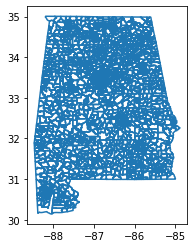

In [4]:
vest_al_20.boundary.plot()

In [5]:
vest_al_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'GEOID20', 'NAME20', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREOWRI', 'G20USSRTUB', 'G20USSDJON',
       'G20USSOWRI', 'G20SSCRSHA', 'G20SSCOWRI', 'G20SSCRMEN', 'G20SSCOWR2',
       'G20SACRTHO', 'G20SACOWRI', 'G20SACRFRI', 'G20SACOWR2', 'G20SCCRWIN',
       'G20SCCOWRI', 'G20SCCRKEL', 'G20SCCOWR2', 'G20PSCRCAV', 'G20PSCDCAS',
       'G20PSCOWRI', 'geometry'],
      dtype='object')

In [6]:
vest_al_20.head(5)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,NAME20,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREOWRI,G20USSRTUB,...,G20SACRFRI,G20SACOWR2,G20SCCRWIN,G20SCCOWRI,G20SCCRKEL,G20SCCOWR2,G20PSCRCAV,G20PSCDCAS,G20PSCOWRI,geometry
0,01,013,000100,01013000100,Monterey School House,25,37,2,0,25,...,26,1,26,1,25,1,25,35,0,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
1,01,013,000181,01013000181,Bolling,100,50,0,0,95,...,101,1,101,1,99,1,99,48,0,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
2,01,053,000080,01053000080,Rock Hill-Ridge VFD,265,60,3,0,251,...,262,5,259,6,262,4,257,63,0,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
3,01,053,000120,01053000120,Damascus-Boykin School,180,143,2,1,172,...,189,2,189,2,189,2,171,145,0,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
4,01,053,000100,01053000100,Bradley VFD,68,2,0,0,67,...,70,0,70,0,70,0,69,2,0,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."


### Create a FIPs dictionary

In [8]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Alabama"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
al_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Election Results

### Load, Pivot, Clean Election Results

There is a directory of excel files that need to be pivoted of election results. 

First, confirm that the file structure is the same for all of the files:

In [13]:
files = os.listdir('./raw-from-source/SOS/2020GeneralPrecinctResults/')

In [22]:
temp = pd.read_excel('./raw-from-source/SOS/2020GeneralPrecinctResults/2020-General-Autauga.xls')
columns = temp.columns
print(columns)

flag = True
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2020GeneralPrecinctResults/' + file)
    if columns.to_list()[:3] != temp.columns.to_list()[:3]:
        print(columns)
        print(temp.columns)
        flag = False
if flag:
    print('All files have the same first 3 columns: ', columns.to_list()[:3])

Index(['Contest Title', 'Party', 'Candidate', '10 JONES COMM_ CTR_',
       '100 TRINITY METHODIST', '110 CENTRAL AL ELECTRIC',
       '140 AUTAUGAVILLE VFD', '150 PRATTMONT BAPTIST',
       '160 DOSTER COMM_ CTR_', '170 CAMELLIA BAPTIST CHURCH',
       '180 OLD KINGSTON VFD', '20 HERITAGE BAPTIST', '220 UPPER KINGSTON',
       '230 COUNTY LINE BAPTIST', '30 BILLINGSLEY COMM_ CTR_',
       '40 E_ MEMORIAL CHRISTIAN', '50 WHITE CITY VFD', '60 MARBURY MIDDLE',
       '70 BOONE'S CHAPEL', '80 INDEPENDENCE VFD', '90 BOOTH VFD', 'ABSENTEE',
       'PROVISIONAL'],
      dtype='object')
All files have the same first 3 columns:  ['Contest Title', 'Party', 'Candidate']


Next, go through and pivot each file, clean them, and concatenate. 

In [173]:
def pivot_clean_county_file(df, county_name): 
    """Given a dataframe, pivot the table, order and rename columns, and return the cleaned table that can be concatenated. """
    
    df_pivot = pd.pivot_table(df,values=[x for x in df.columns.to_list() if x not in ('Contest Title','Party','Candidate')],
                              columns=['Contest Title',"Candidate"],aggfunc=sum)
    df_pivot['county'] = county_name
    df_pivot.reset_index(inplace = True)
    df_pivot.columns = [(x.strip(), y.strip()) for x,y in df_pivot.columns.values]
    
    if county_name in ('Randolph'):
        president = [('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Donald J. Trump Michael R. Penc'), 
            ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Joseph R. Biden Kamala D. Harri'), 
            ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Jo Jorgensen Jeremy "Spike" Coh'), 
            ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In')]
    elif county_name in ('Barbour'):
        president = [('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Donald J. Trump'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Joseph R. Biden'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Jo Jorgensen Jeremy "Spike" Cohen'), 
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In')]
    else:
        president = [('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Donald J. Trump'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Joseph R. Biden'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Jo Jorgensen'),
                          ('PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES', 'Write-In')]
    
    clean_df = df_pivot[[('index',''),('county','')] + president + 
                          [('UNITED STATES SENATOR', 'Tommy Tuberville'),
                          ('UNITED STATES SENATOR', 'Doug Jones'),
                          ('UNITED STATES SENATOR', 'Write-In'),
                          ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Greg Shaw'),
                          ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 1', 'Write-In'),
                          ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Brad Mendheim'),
                          ('ASSOCIATE JUSTICE OF THE SUPREME COURT, PLACE 2', 'Write-In'),
                          ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'William C. "Bill" Thompson'),
                          ('COURT OF CIVIL APPEALS JUDGE, PLACE 1', 'Write-In'),
                          ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Matt Fridy'),
                          ('COURT OF CIVIL APPEALS JUDGE, PLACE 2', 'Write-In'),
                          ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Mary Windom'),
                          ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 1', 'Write-In'),
                          ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Beth Kellum'),
                          ('COURT OF CRIMINAL APPEALS JUDGE, PLACE 2', 'Write-In'),
                          ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Twinkle Andress Cavanaugh'),
                          ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Laura Casey'),
                          ('PRESIDENT, PUBLIC SERVICE COMMISSION', 'Write-In')]]
    clean_df.columns = ['precinct','county',
                        'G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREOWRI',
                        'G20USSRTUB','G20USSDJON','G20USSOWRI',
                        'G20SSCRSHA','G20SSCOWRI',
                        'G20SSCRMEN','G20SSCOWR2',
                        'G20SACRTHO','G20SACOWRI',
                        'G20SACRFRI','G20SACOWR2',
                        'G20SCCRWIN','G20SCCOWRI',
                        'G20SCCRKEL','G20SCCOWR2',
                        'G20PSCRCAV','G20PSCDCAS','G20PSCOWRI']
    
    return clean_df


In [196]:
flag = 0
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2020GeneralPrecinctResults/' + file)
#     print(file.split('-')[2][:-4])
    clean_df = pivot_clean_county_file(temp, file.split('-')[2][:-4])
    if flag == 0:
        results_2020 = clean_df
        flag = 1
    else:
        results_2020 = pd.concat([results_2020, clean_df])

Add county fips to election results file

In [197]:
# Change column names to match the county fips dict
results_2020.loc[results_2020['county'] == 'StClair', 'county'] = 'St Clair'
results_2020.loc[results_2020['county'] == 'DeKalb', 'county'] = 'De Kalb'

#Map to the correct FIP
results_2020["county_fips"]=results_2020["county"].map(al_fips_dict).fillna(results_2020["county"])

#Print out the FIPS to make sure they all are in the correct format
results_2020["county_fips"].unique()

array(['015', '007', '039', '077', '091', '017', '111', '103', '061',
       '083', '029', '041', '019', '047', '025', '071', '107', '069',
       '001', '129', '105', '097', '045', '051', '055', '043', '117',
       '037', '065', '087', '053', '085', '123', '125', '059', '099',
       '115', '049', '127', '057', '063', '093', '075', '005', '003',
       '113', '095', '121', '133', '073', '067', '031', '011', '109',
       '033', '119', '021', '035', '101', '023', '131', '027', '079',
       '009', '081', '089', '013'], dtype=object)

In [210]:
results_2020.shape

(2111, 25)

In [211]:
vest_al_20.shape

(1972, 28)

## Compare Election Results Totals

### Compare Total Votes

In [198]:
races = [x for x in vest_al_20.columns if 'G20' in x]
races

['G20PRERTRU',
 'G20PREDBID',
 'G20PRELJOR',
 'G20PREOWRI',
 'G20USSRTUB',
 'G20USSDJON',
 'G20USSOWRI',
 'G20SSCRSHA',
 'G20SSCOWRI',
 'G20SSCRMEN',
 'G20SSCOWR2',
 'G20SACRTHO',
 'G20SACOWRI',
 'G20SACRFRI',
 'G20SACOWR2',
 'G20SCCRWIN',
 'G20SCCOWRI',
 'G20SCCRKEL',
 'G20SCCOWR2',
 'G20PSCRCAV',
 'G20PSCDCAS',
 'G20PSCOWRI']

In [199]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_al_20[i])
    sum_var_2 += np.sum(results_2020[i])
print(sum_var_1)
print(sum_var_2)

16388212
16388212.0


### Compare County Totals

The `compare()` method shows rows where the values are different, by default. So displaying nothing here is good, all county race totals are equal. 

In [209]:
vest_al_20.groupby('COUNTYFP20')['G20PRERTRU'].sum().compare(results_2020.groupby('county_fips')['G20PRERTRU'].sum())

,self,other


In [208]:
vest_al_20.groupby('COUNTYFP20')['G20PRERTRU'].sum().compare(results_2020.groupby('county_fips')['G20PRERTRU'].sum(), keep_shape = True, keep_equal = True)

,self,other
001,19838,19838.0
003,83544,83544.0
005,5622,5622.0
007,7525,7525.0
009,24711,24711.0
...,...,...
125,51117,51117.0
127,26002,26002.0
129,6564,6564.0
131,1833,1833.0


### Compare Race Totals

In [206]:
for race in races:
    diff_val = sum(vest_al_20[race])-sum(results_2020[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_20[race]), "\tRDH sum: ", sum(results_2020[race]))
    else:
        print(race+": EQUAL")

G20PRERTRU: EQUAL
G20PREDBID: EQUAL
G20PRELJOR: EQUAL
G20PREOWRI: EQUAL
G20USSRTUB: EQUAL
G20USSDJON: EQUAL
G20USSOWRI: EQUAL
G20SSCRSHA: EQUAL
G20SSCOWRI: EQUAL
G20SSCRMEN: EQUAL
G20SSCOWR2: EQUAL
G20SACRTHO: EQUAL
G20SACOWRI: EQUAL
G20SACRFRI: EQUAL
G20SACOWR2: EQUAL
G20SCCRWIN: EQUAL
G20SCCOWRI: EQUAL
G20SCCRKEL: EQUAL
G20SCCOWR2: EQUAL
G20PSCRCAV: EQUAL
G20PSCDCAS: EQUAL
G20PSCOWRI: EQUAL


# Precinct Shapefile

## Load in the shapefiles

### 2020 TIGER/Line

> Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

Link to the 2020 TIGER/Line files for AL, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/01_ALABAMA/01/

In [212]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_01_vtd20/tl_2020_01_vtd20.shp')

In [213]:
tiger_vtd.head(1)

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,01,013,000010,01013000010,A,MONTEREY SCHOOL HOUSE,MONTEREY SCHOOL HOUSE,00,G5240,N,52684413,65831,+31.9295188,-086.8948172,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."


In [214]:
tiger_vtd.shape

(1837, 15)

<AxesSubplot:>

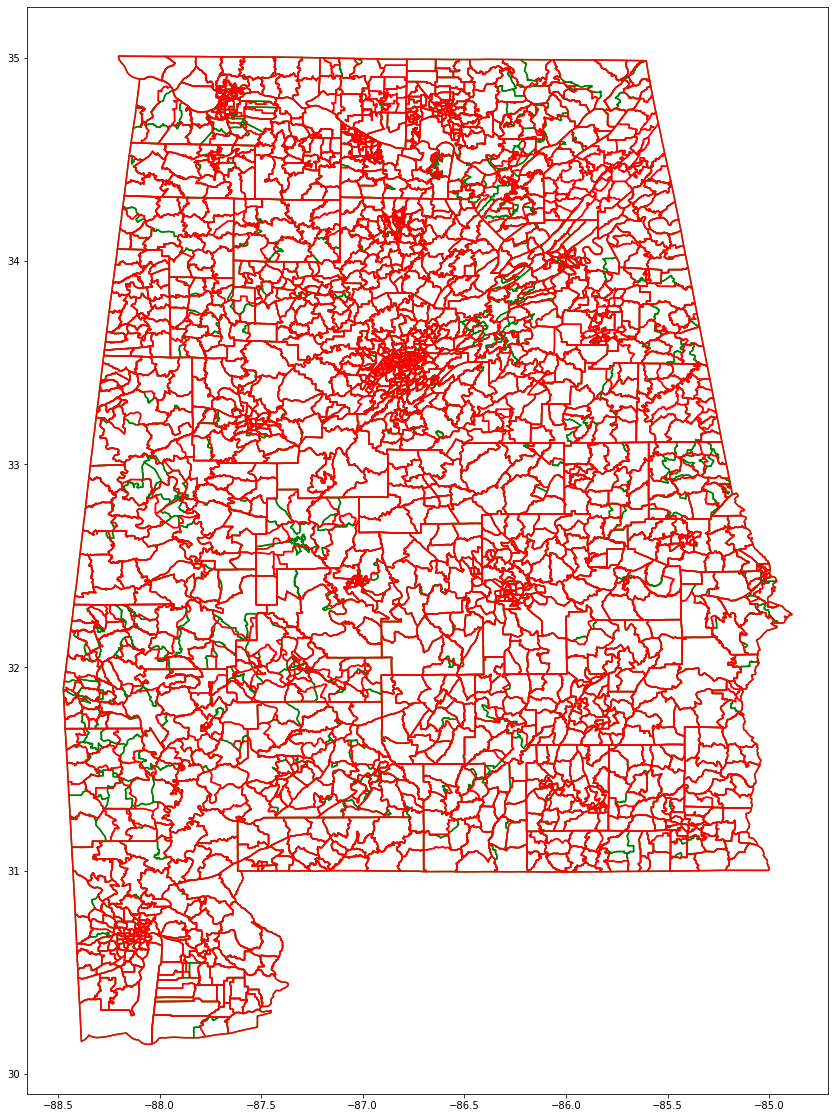

In [215]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(20,20),color="green")
vest_al_20.boundary.plot(figsize=(20,20),ax=ax,color="red")

### Shp from SOS

> Precinct shapefiles initially from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.


See the README for the list of PDF maps that are available and the few contacts we made to counties. All of these counties do not have shapefiles available for download on their website, as of 6/4/2021.  